<a href="https://colab.research.google.com/github/EdwSanA/DPro_Tareas/blob/main/SVM_v_mejorada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

iter 0/1500 | sum(λy)=0.000e+00 | λ>=0: True
iter 150/1500 | sum(λy)=-8.327e-17 | λ>=0: False
iter 300/1500 | sum(λy)=3.469e-17 | λ>=0: False
iter 450/1500 | sum(λy)=4.163e-17 | λ>=0: False
iter 600/1500 | sum(λy)=1.388e-17 | λ>=0: False
iter 750/1500 | sum(λy)=-2.776e-17 | λ>=0: False
iter 900/1500 | sum(λy)=-1.943e-16 | λ>=0: False
iter 1050/1500 | sum(λy)=0.000e+00 | λ>=0: False
iter 1200/1500 | sum(λy)=4.163e-17 | λ>=0: False
iter 1350/1500 | sum(λy)=4.163e-17 | λ>=0: False
SVs: 45 | b=0.4172

[Scratch SVM - lineal]
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0


/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:2293: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


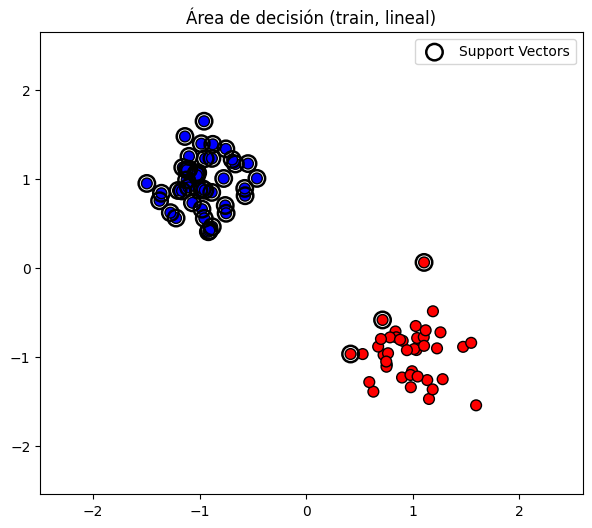

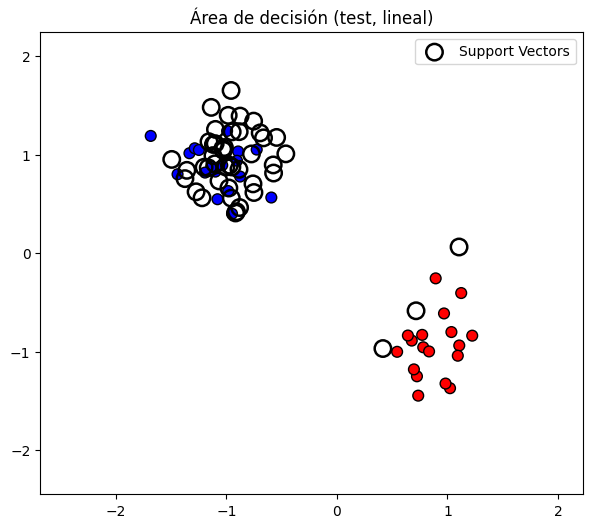


[sklearn SVC - lineal]
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0

[Scratch SVM - kernel polinomial d=2]
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0


/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:2293: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


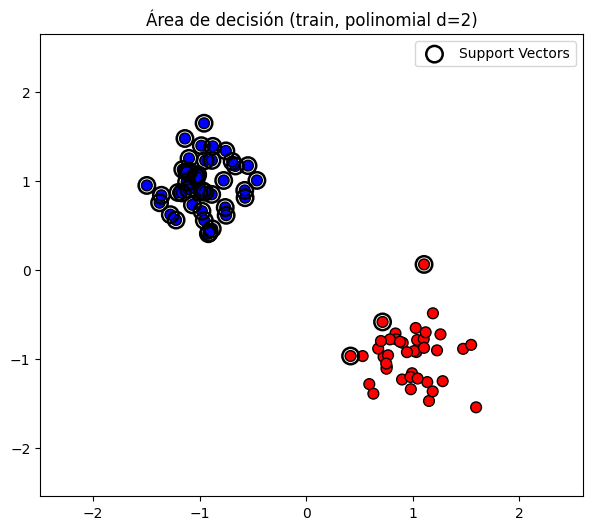

In [1]:
# SVM Hard-Margin from scratch (dual, con b y restricción de igualdad)
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.svm import SVC

# ===============================
# ScratchSVMClassifier
# ===============================
class ScratchSVMClassifier:
    """
    SVM hard-margin (dual) con kernels lineal y polinomial.
    Impone sum_i λ_i y_i = 0 en cada iteración y calcula el sesgo b.
    """

    def __init__(self, num_iter=1000, lr=1e-3, kernel='linear', threshold=1e-5,
                 verbose=False, gamma=1.0, theta0=0.0, d=2):
        self.iter = int(num_iter)
        self.lr = float(lr)
        self.kernel = kernel
        self.threshold = float(threshold)
        self.verbose = bool(verbose)
        # hiperparámetros del kernel polinomial
        self.gamma = float(gamma)
        self.theta0 = float(theta0)
        self.d = int(d)
        # se rellenan al entrenar
        self.lambdas = None
        self.b = 0.0
        self.X_sv = None
        self.y_sv = None
        self.lam_sv = None
        self.index_support_vectors = None
        self.n_support_vectors = 0

    # ----- kernels -----
    def _linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def _poly_kernel(self, x1, x2):
        # (γ x^T z + θ0)^d
        return (self.gamma * np.dot(x1, x2) + self.theta0) ** self.d

    def _kernel(self, x1, x2):
        if self.kernel == 'linear':
            return self._linear_kernel(x1, x2)
        elif self.kernel == 'polly':  # (nombre como en el enunciado)
            return self._poly_kernel(x1, x2)
        else:
            raise ValueError("Kernel no soportado: use 'linear' o 'polly'.")

    # ----- entrenamiento (dual gradient ascent) -----
    def fit(self, X, y, X_val=None, y_val=None):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1)
        assert set(np.unique(y)) == {-1.0, 1.0}, "Las etiquetas deben ser {-1, +1}."

        n_samples = X.shape[0]
        self.lambdas = np.zeros(n_samples, dtype=float)

        # Precalcular la matriz kernel K_ij = k(x_i, x_j) para acelerar
        K = np.empty((n_samples, n_samples), dtype=float)
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self._kernel(X[i], X[j])

        y_col = y.reshape(-1, 1)

        for it in range(self.iter):
            # gradiente de la dual:
            # g_i = 1 - sum_j λ_j y_i y_j K_ij
            g = 1.0 - ( (self.lambdas * y) @ K ) * y

            # paso de ascenso
            self.lambdas += self.lr * g

            # proyección a λ_i >= 0
            self.lambdas[self.lambdas < 0.0] = 0.0

            # proyección a la restricción de igualdad: sum_i λ_i y_i = 0
            # proyectamos al hiperplano: λ <- λ - ( (y^T λ) / (y^T y) ) y
            s = np.dot(y, self.lambdas)          # y^T λ
            denom = np.dot(y, y)                 # y^T y = n (porque y_i ∈ {-1,1})
            self.lambdas -= (s / denom) * y

            if self.verbose and (it % max(1, self.iter // 10) == 0):
                print(f"iter {it}/{self.iter} | sum(λy)={np.dot(y, self.lambdas):.3e} | "
                      f"λ>=0: {np.all(self.lambdas>=-1e-12)}")

        # ---- vectores de soporte ----
        sv_mask = self.lambdas > self.threshold
        self.index_support_vectors = np.where(sv_mask)[0]
        self.X_sv = X[sv_mask]
        self.y_sv = y[sv_mask]
        self.lam_sv = self.lambdas[sv_mask]
        self.n_support_vectors = self.X_sv.shape[0]

        # ---- sesgo b (usar KKT: y_i (Σ λ_j y_j k(x_i,x_j) + b ) = 1 para SVs) ----
        # b = mean_i[ y_i - Σ_j λ_j y_j k(x_i, x_j) ], sobre SVs
        if self.n_support_vectors == 0:
            self.b = 0.0
        else:
            decision_on_sv = np.zeros(self.n_support_vectors)
            for idx_i, xi in enumerate(self.X_sv):
                s = 0.0
                for lam, yj, xj in zip(self.lam_sv, self.y_sv, self.X_sv):
                    s += lam * yj * self._kernel(xi, xj)
                decision_on_sv[idx_i] = s
            self.b = np.mean(self.y_sv - decision_on_sv)

        if self.verbose:
            print(f"SVs: {self.n_support_vectors} | b={self.b:.4f}")

    # ----- función de decisión y predicción -----
    def _decision_function(self, X):
        X = np.asarray(X, dtype=float)
        scores = np.zeros(X.shape[0], dtype=float)
        for i, x in enumerate(X):
            s = 0.0
            for lam, y_sv, x_sv in zip(self.lam_sv, self.y_sv, self.X_sv):
                s += lam * y_sv * self._kernel(x, x_sv)
            scores[i] = s + self.b
        return scores

    def predict(self, X):
        return np.sign(self._decision_function(X)).astype(int)

# ===============================
# Utilidades de visualización
# ===============================
def plot_decision_boundary(model, X, y, title="Área de decisión - SVM Scratch"):
    X = np.asarray(X)
    y = np.asarray(y)
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(7, 6))
    plt.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf], alpha=0.25, cmap=plt.cm.bwr)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr, edgecolors="k", s=60)
    # resaltar SVs
    if getattr(model, "X_sv", None) is not None and model.X_sv.size > 0:
        plt.scatter(model.X_sv[:, 0], model.X_sv[:, 1],
                    s=140, facecolors='none', edgecolors='k', linewidths=1.8,
                    label="Support Vectors")
        plt.legend()
    plt.title(title)
    plt.show()

# ===============================
# Demo con dataset 2D simple (cumple Problemas 4 y 5)
# ===============================
# Datos binarios fáciles de separar
X, y = datasets.make_blobs(n_samples=120, n_features=2, centers=2, cluster_std=1.0, random_state=42)
y = np.where(y == 0, -1, 1)  # etiquetas -1 / +1

# Split + estandarización (mejora estabilidad del entrenamiento)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# ----- SVM scratch (kernel lineal) -----
svm_scratch = ScratchSVMClassifier(num_iter=1500, lr=2e-3, kernel="linear",
                                   threshold=1e-5, verbose=True)
svm_scratch.fit(X_train_s, y_train)
y_pred = svm_scratch.predict(X_test_s)

print("\n[Scratch SVM - lineal]")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))

plot_decision_boundary(svm_scratch, X_train_s, y_train, "Área de decisión (train, lineal)")
plot_decision_boundary(svm_scratch, X_test_s,  y_test,  "Área de decisión (test, lineal)")

# ----- Comparación con scikit-learn (C grande ≈ hard margin) -----
sk_svm = SVC(kernel="linear", C=1e6)
sk_svm.fit(X_train_s, y_train)
y_pred_sk = sk_svm.predict(X_test_s)
print("\n[sklearn SVC - lineal]")
print("Accuracy :", accuracy_score(y_test, y_pred_sk))
print("Precision:", precision_score(y_test, y_pred_sk))
print("Recall   :", recall_score(y_test, y_pred_sk))

# ----- Kernel polinomial (Problema 6) -----
svm_poly = ScratchSVMClassifier(num_iter=2000, lr=2e-3, kernel="polly",
                                gamma=1.0, theta0=1.0, d=2, threshold=1e-5, verbose=False)
svm_poly.fit(X_train_s, y_train)
y_pred_poly = svm_poly.predict(X_test_s)
print("\n[Scratch SVM - kernel polinomial d=2]")
print("Accuracy :", accuracy_score(y_test, y_pred_poly))
print("Precision:", precision_score(y_test, y_pred_poly))
print("Recall   :", recall_score(y_test, y_pred_poly))
plot_decision_boundary(svm_poly, X_train_s, y_train, "Área de decisión (train, polinomial d=2)")
